#Kalman Filters


Kalman Filter Beta Estimation Example from [Dr. Aidan O'Mahony's blog.](http://www.thealgoengineer.com/2014/online_linear_regression_kalman_filter/)


---

##What is a Kalman Filter?

The Kalman filter is an algorithm that uses noisy observations of a system over time to estimate the parameters of the system (some of which are unobservable) and predict future observations. At each time step, it makes a prediction, takes in a measurement, and updates itself based on how the prediction and measurement compare.

The algorithm is as follows:
1. Take as input a mathematical model of the system, i.e.
  * the transition matrix, which tells us how the system evolves from one state to another. For instance, if we are modeling the movement of a car, then the next values of position and velocity can be computed from the previous ones using kinematic equations. Alternatively, if we have a system which is fairly stable, we might model its evolution as a random walk. If you want to read up on Kalman filters, note that this matrix is usually called $A$.
  * the observation matrix, which tells us the next measurement we should expect given the predicted next state. If we are measuring the position of the car, we just extract the position values stored in the state. For a more complex example, consider estimating a linear regression model for the data. Then our state is the coefficients of the model, and we can predict the next measurement from the linear equation. This is denoted $H$.
  * any control factors that affect the state transitions but are not part of the measurements. For instance, if our car were falling, gravity would be a control factor. If the noise does not have mean 0, it should be shifted over and the offset put into the control factors. The control factors are summarized in a matrix $B$ with time-varying control vector $u_t$, which give the offset $Bu_t$.
  * covariance matrices of the transition noise (i.e. noise in the evolution of the system) and measurement noise, denoted $Q$ and $R$, respectively.
2. Take as input an initial estimate of the state of the system and the error of the estimate, $\mu_0$ and $\sigma_0$.
3. At each timestep:
  * estimate the current state of the system $x_t$ using the transition matrix
  * take as input new measurements $z_t$
  * use the conditional probability of the measurements given the state, taking into account the uncertainties of the measurement and the state estimate, to update the estimated current state of the system $x_t$ and the covariance matrix of the estimate $P_t$

[This graphic](https://upload.wikimedia.org/wikipedia/commons/a/a5/Basic_concept_of_Kalman_filtering.svg) illustrates the procedure followed by the algorithm. 

It's very important for the algorithm to keep track of the covariances of its estimates. This way, it can give us a more nuanced result than simply a point value when we ask for it, and it can use its confidence to decide how much to be influenced by new measurements during the update process. The more certain it is of its estimate of the state, the more skeptical it will be of measurements that disagree with the state.

By default, the errors are assumed to be normally distributed, and this assumption allows the algorithm to calculate precise confidence intervals. It can, however, be implemented for non-normal errors.

In [1]:
# Import a Kalman filter and other useful libraries
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

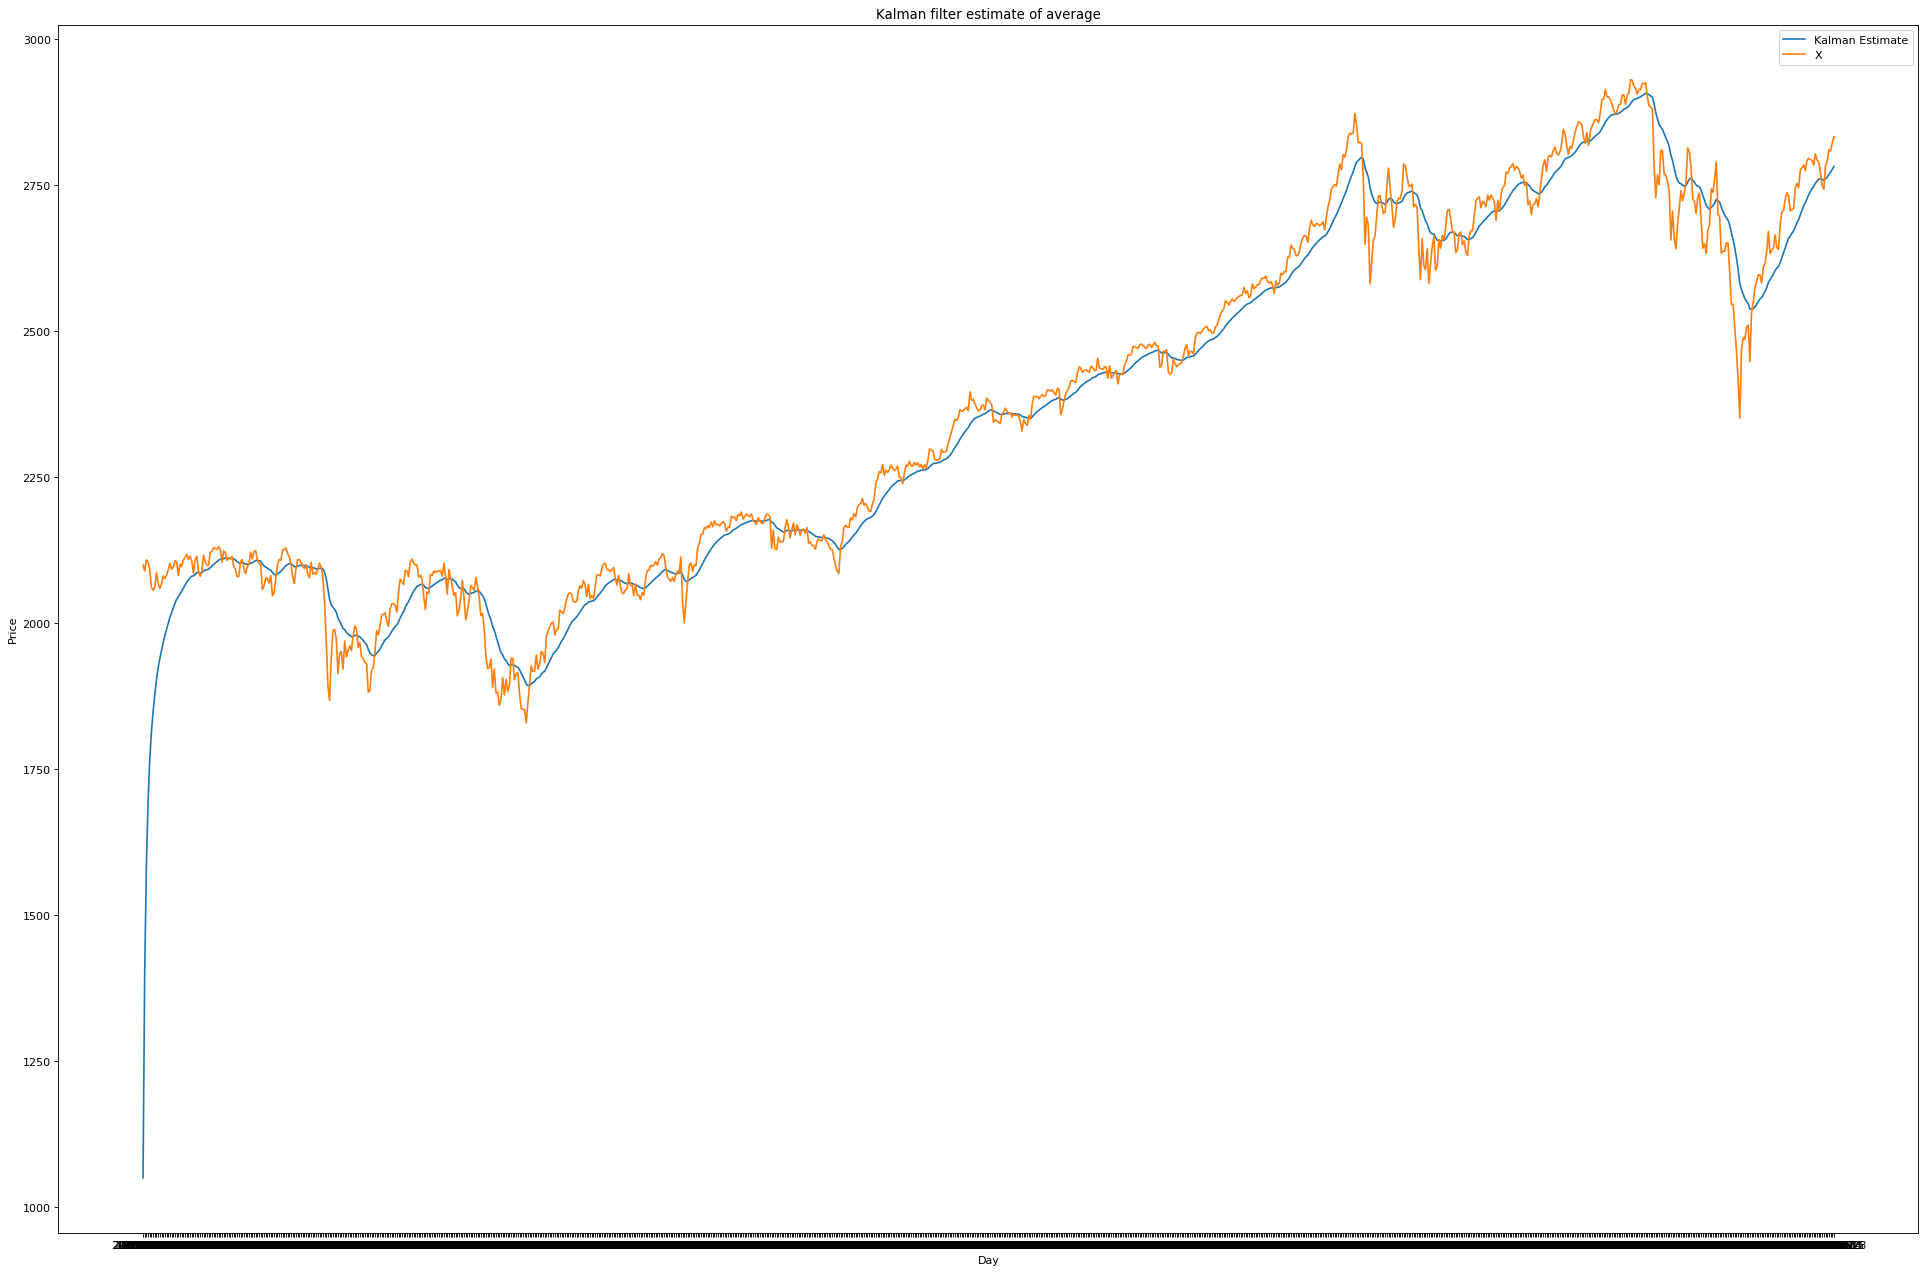

In [2]:
# Load pricing data for a security
start = '2013-01-01'
end = '2015-01-01'
x = pd.read_csv('./s&p_2015-2019_daily.csv',index_col='Date')


# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(x['Close'])
state_means = pd.Series(state_means.flatten(), index=x.index)

# Compute the rolling mean with various lookback windows
mean30 = x.rolling(window = 30).mean()
mean60 = x.rolling(window = 60).mean()
mean90 = x.rolling(window = 90).mean()

# Plot original data and estimated mean
plt.figure(num=None, figsize=(30, 20), dpi=80)
plt.plot(state_means)
plt.plot(x['Close'])
#plt.plot(mean30)
#plt.plot(mean60)
#plt.plot(mean90)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price');

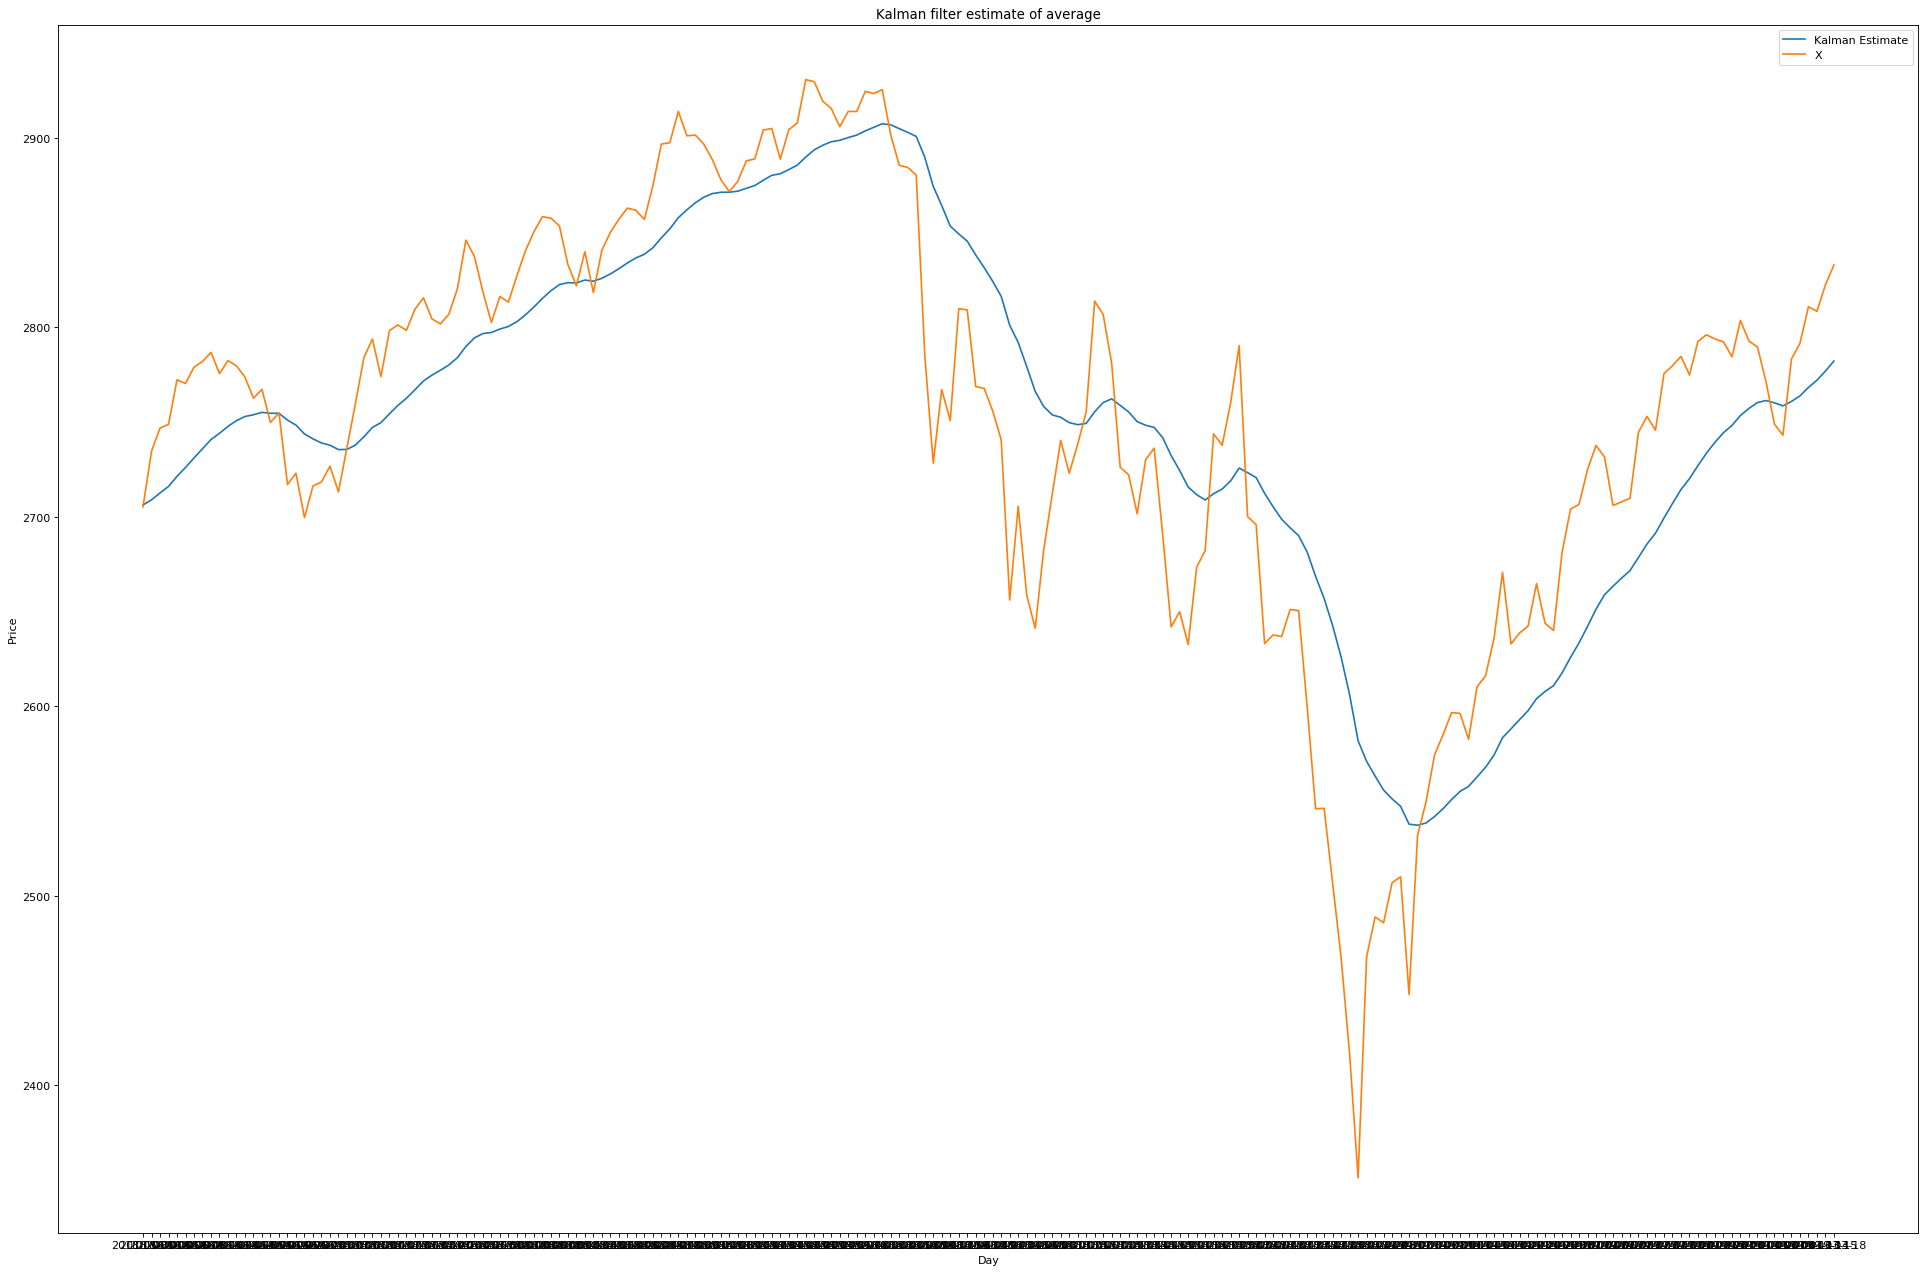

In [3]:
plt.figure(num=None, figsize=(30, 20), dpi=80, facecolor='w', edgecolor='k')
plt.plot(state_means[-200:])
plt.plot(x['Close'][-200:])
#plt.plot(mean30[-200:])
#plt.plot(mean60[-200:])
#plt.plot(mean90[-200:])
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price');

In [4]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = mean_squared_error(state_means, x['Close'])
print(rms)

3922.726546423584


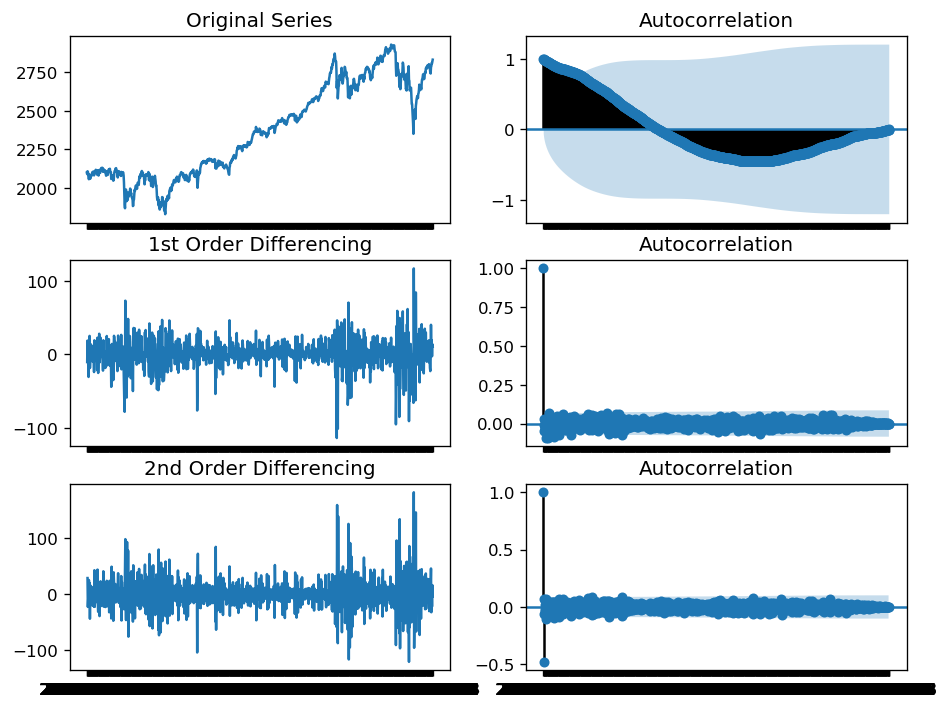

In [5]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df = pd.read_csv('./s&p_2015-2019_daily.csv',index_col='Date')['Close']

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

D:\04.Programme\Anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\04.Programme\Anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test Mean Squared Error (smaller the better fit): 783.708


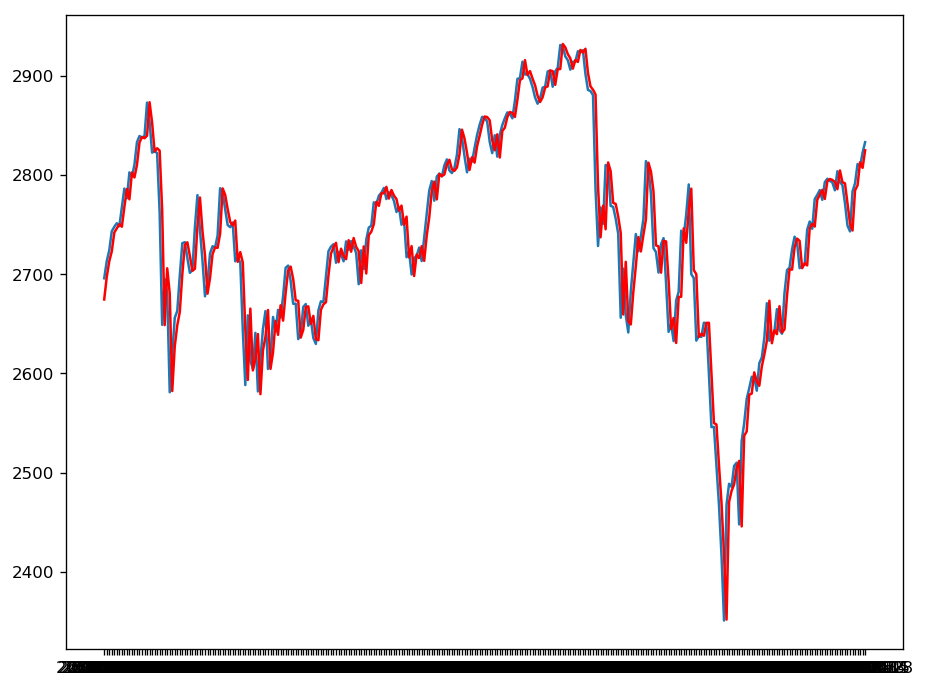

In [6]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

#get data
def GetData(fileName):
    return read_csv(fileName, header=0, parse_dates=[0], index_col=0).values

#Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
	model = ARIMA(Actual, order=(P, D, Q))
	model_fit = model.fit(disp=0)
	prediction = model_fit.forecast()[0]
	return prediction
    
#Get exchange rates
ActualData = pd.read_csv('./s&p_2015-2019_daily.csv',index_col='Date')['Close']
#Size of exchange rates
NumberOfElements = len(ActualData)

#Use 70% of data as training, rest 30% to Test model
TrainingSize = int(NumberOfElements * 0.7)
TrainingData = ActualData[0:TrainingSize]
TestData = ActualData[TrainingSize:NumberOfElements]

#new arrays to store actual and predictions
Actual = [x for x in TrainingData]
Predictions = list()


#in a for loop, predict values using ARIMA model
for timepoint in range(len(TestData)):
	ActualValue =  TestData[timepoint]
	#forcast value
	Prediction = StartARIMAForecasting(Actual, 3,1,1)    
	#print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
	#add it in the list
	Predictions.append(Prediction)
	Actual.append(ActualValue)

#Print MSE to see how good the model is
Error = mean_squared_error(TestData, Predictions)
print('Test Mean Squared Error (smaller the better fit): %.3f' % Error)
# plot
pyplot.plot(TestData)
pyplot.plot(Predictions, color='red')
pyplot.show()

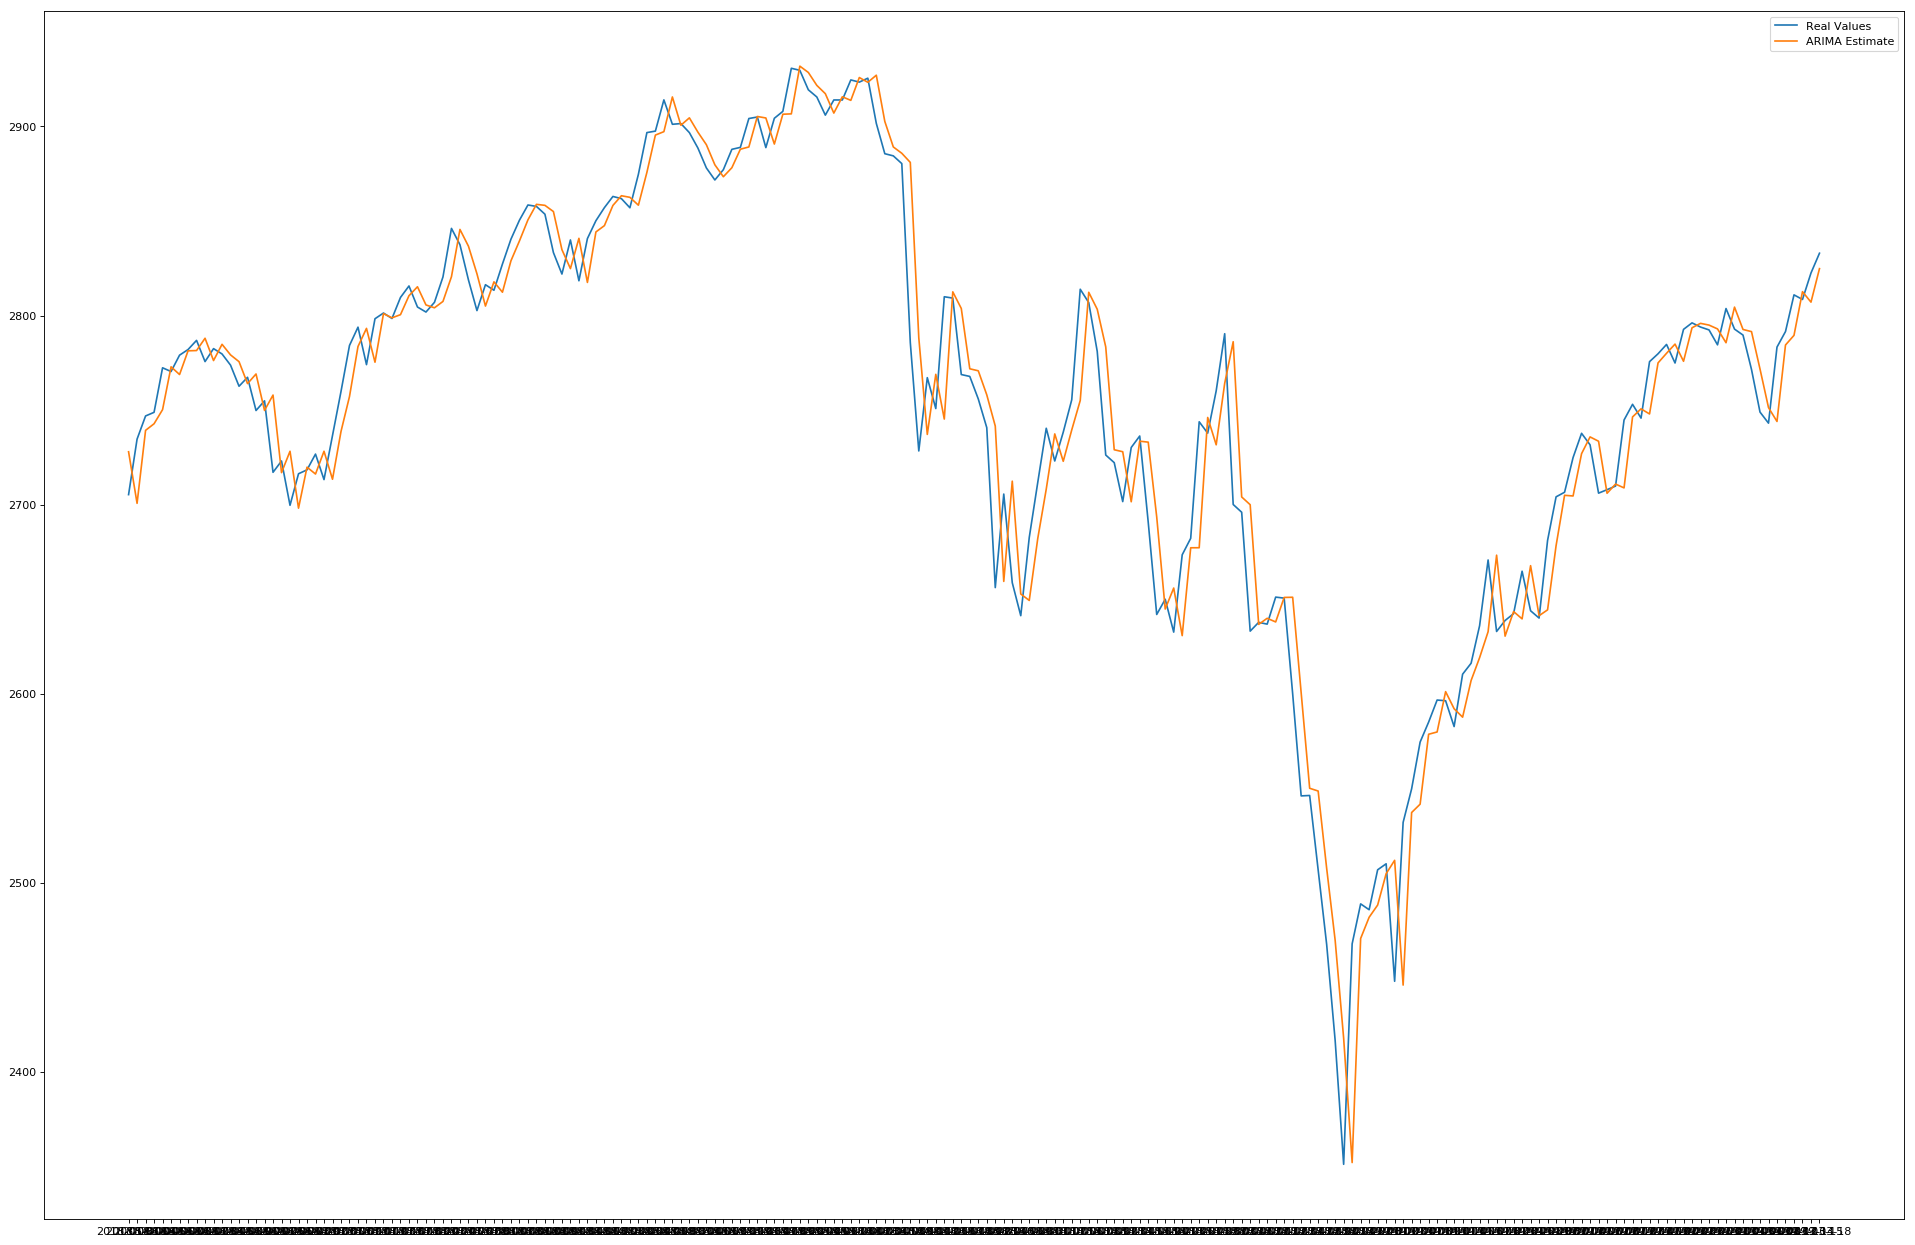

In [7]:
plt.figure(num=None, figsize=(30, 20), dpi=80, facecolor='w', edgecolor='k')
plt.plot(TestData[-200:])
plt.plot(Predictions[-200:])
plt.legend(['Real Values','ARIMA Estimate'])

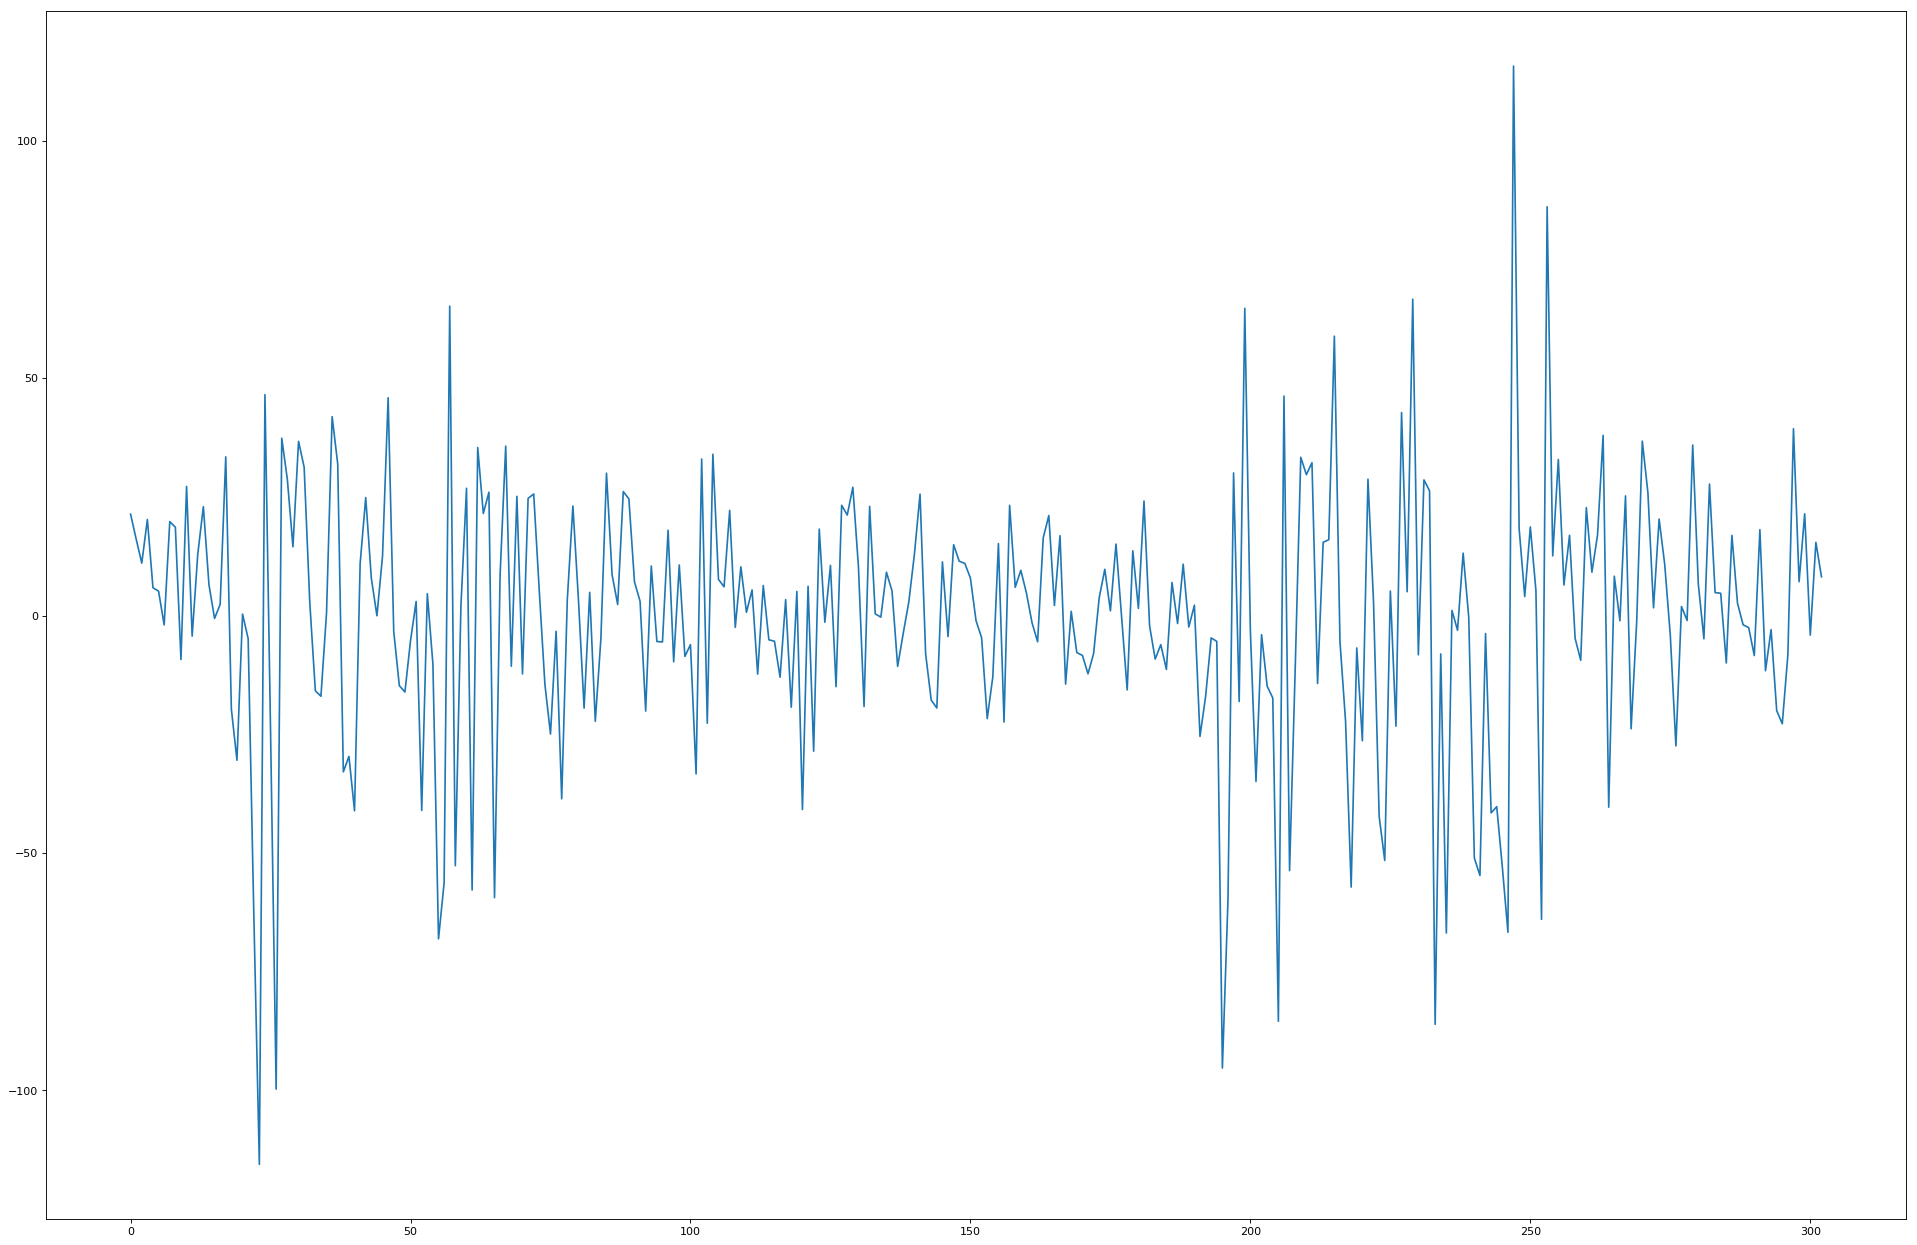

In [8]:
plt.figure(num=None, figsize=(30, 20), dpi=80, facecolor='w', edgecolor='k')
diff=[]
#print(size(TestData,Predictions))
for i in range(len(TestData)):
    diff.append(TestData[i]-Predictions[i])
plt.plot(diff)
plt.show()

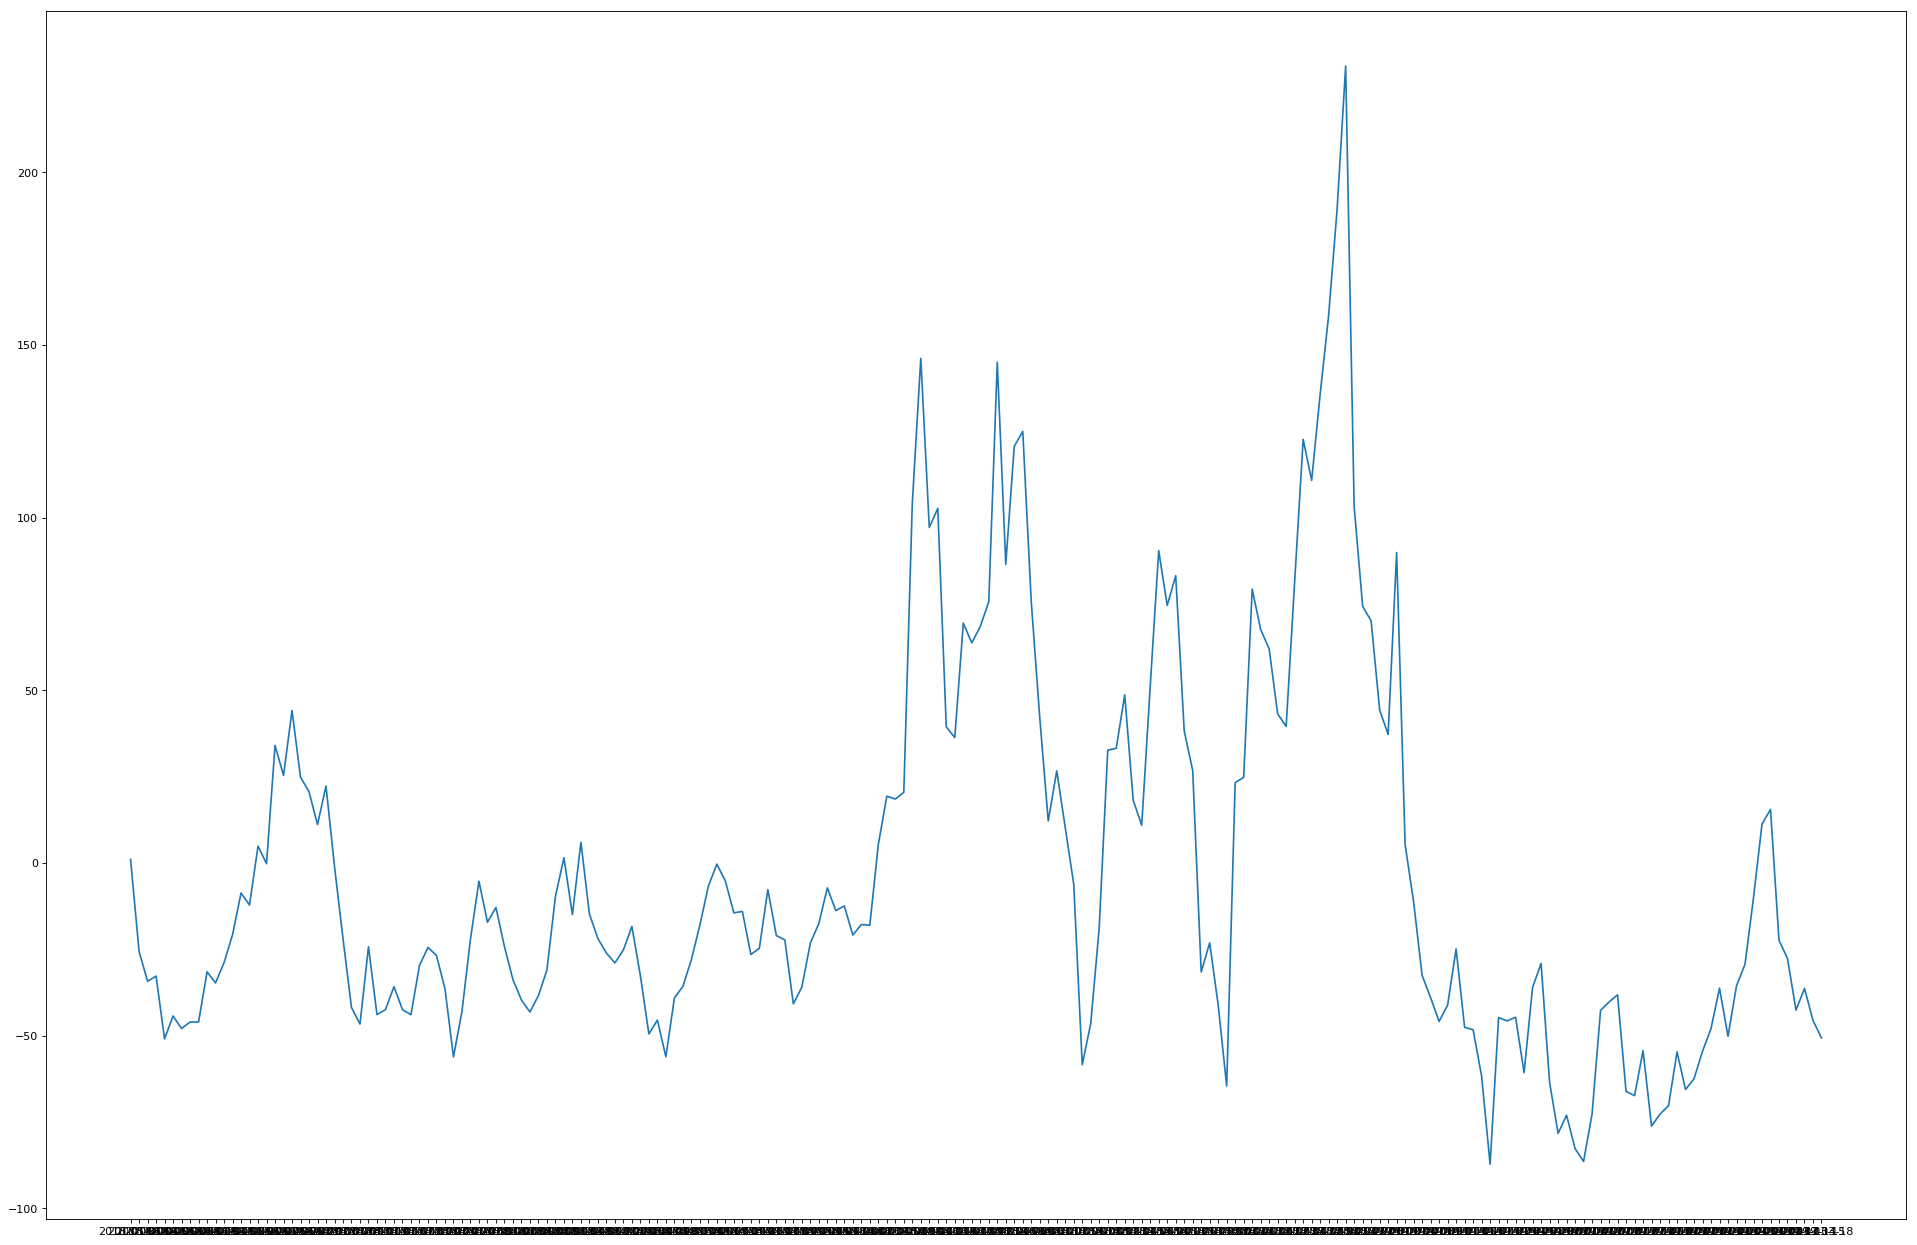

3090.76480897734

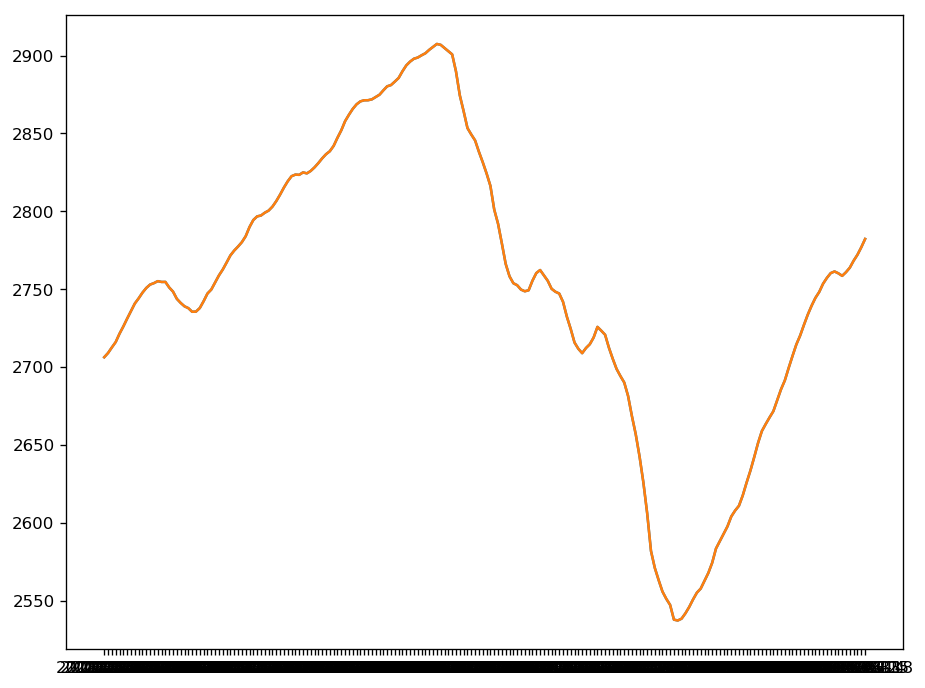

In [9]:
plt.figure(num=None, figsize=(30, 20), dpi=80)
plt.plot(state_means[-200:]-x['Close'][-200:])
plt.show()
diff=[]
for i in range(200):
    diff.append(state_means[-201+1+i])
plt.plot(diff)
plt.plot(state_means[-200:])
mean_squared_error(diff,x['Close'][-200:])